In [1]:
import fsps
import pickle
import numpy as np 
import astropy.units as u
from astropy.cosmology import z_at_value
# -- gqp_mc --
from gqp_mc import util as UT
from gqp_mc import fitters as Fitters
# -- plotting --
import matplotlib as mpl 
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [2]:
speculate = Fitters.iSpeculator()
speculate_fsps = Fitters.iSpeculator(model_name='fsps')

In [3]:
# Generate some random SED and sort out wavelength selection
theta = np.load('_theta.npy')
_wave, sspLum = np.load('fsps_sspLum.npy')

In [4]:
spectrum = speculate._emulator(theta)

In [5]:
w_fsps, spectrum_fsps = speculate_fsps._fsps_model(theta)

/anaconda2/envs/gqp/lib/python3.7/site-packages/gqp_mc-0.1-py3.7.egg/gqp_mc/fitters.py:1514: RuntimeWarning: divide by zero encountered in log10
  self._ssp.params['logzsol'] = np.log10(z/0.0190) # log(Z/Zsun)


In [6]:
print(_wave, sspLum)
print(w_fsps[w_fsps > 2.3e3], spectrum_fsps[w_fsps > 2.3e3])

[2305. 2315. 2325. ... 9950. 9970. 9990.] [0.01621769 0.01613066 0.01588638 ... 0.0164255  0.01644211 0.01723508]
[2.305e+03 2.315e+03 2.325e+03 ... 9.817e+07 9.908e+07 1.000e+08] [1.62176904e-02 1.61306621e-02 1.58863780e-02 ... 2.01653729e-11
 1.92726011e-11 1.84314811e-11]


No handles with labels found to put in legend.


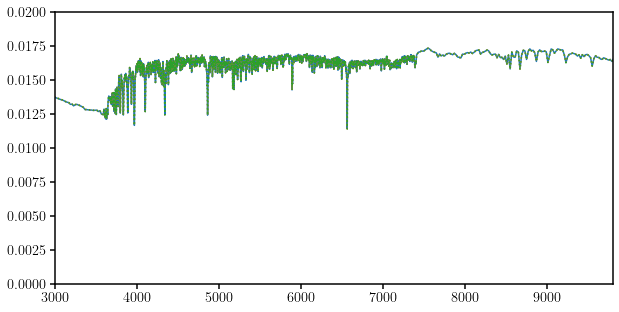

In [8]:
fig = plt.figure(figsize=(10,5))
sub = plt.subplot(111)
sub.plot(speculate._emu_wave, spectrum)
sub.plot(_wave, sspLum, ls=':')
sub.plot(w_fsps, spectrum_fsps, ls=':')

sub.set_xlim(3e3, 9800.)
sub.set_ylim(0.,0.02)
sub.legend(loc='upper right', fontsize=20)

In [9]:
_theta = np.array([0.]+list(theta[:-1]))

zred = z_at_value(speculate.cosmo.age, theta[-1] * u.Gyr)

_w, _spec = speculate.model(_theta, zred=zred, dont_transform=True)

In [10]:
_wave_z = _wave * (1 + zred)
d_lum = speculate.cosmo.luminosity_distance(zred).to(u.cm).value # luminosity distance in cm
flux_z = sspLum * UT.Lsun() / (4. * np.pi * d_lum**2) / (1. + zred) * 1e17 # 10^-17 ergs/s/cm^2/Ang

In [11]:
_w_fsps, _spec_fsps = speculate_fsps.model(_theta, zred=zred, dont_transform=True)

/anaconda2/envs/gqp/lib/python3.7/site-packages/gqp_mc-0.1-py3.7.egg/gqp_mc/fitters.py:1514: RuntimeWarning: divide by zero encountered in log10
  self._ssp.params['logzsol'] = np.log10(z/0.0190) # log(Z/Zsun)


No handles with labels found to put in legend.


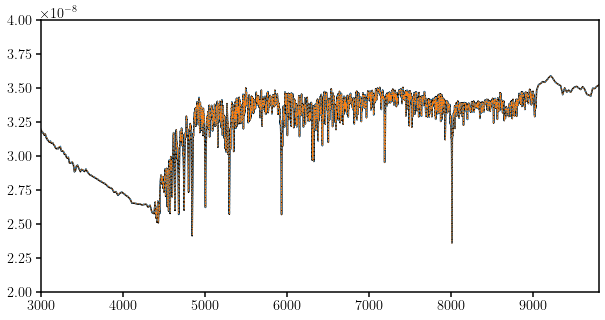

In [19]:
fig = plt.figure(figsize=(10,5))
sub = plt.subplot(111)
sub.plot(_w, _spec, c='k')
sub.plot(_wave_z, flux_z, ls=':')
sub.plot(_w_fsps, _spec_fsps, lw=0.5, ls='--')
sub.set_xlim(3e3, 9800.)
sub.set_ylim(2e-8,0.4e-7)
sub.legend(loc='upper right', fontsize=20)